# 2D example
This notebook shows how to run and analyse a 2D simulation with DISCO-DJ.

### Imports

In [57]:
# Import modules
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
sns.set_style("ticks")
import jax
from jax import config
import numpy as np
from discodj import DiscoDJ
plt.rcParams['image.cmap'] = "rocket"
print(jax.__version__)

0.5.0


### Simulation settings
DISCO-DJ can be run on a GPU (*much* faster) or on a CPU. The following cell detects if a GPU is available and sets the device accordingly.

In [58]:
# Detect if a GPU is available
devices = jax.devices()
device = "gpu" if np.any([d.platform == "gpu" for d in devices]) else "cpu"

Now, we set the name of the analysis and the spatial dimension. The precision can be set to "single" (float32) or "double" (float64; in that case, the Jax config needs to be updated). DISCO-DJ is written in an class-based (yet functional) way, so you need to define a DiscoDJ object that will be used to perform all computations.

In [59]:
# Set the parameters
name = "2D_analysis"
dim = 2

precision = "double"
if precision == "double":
    config.update("jax_enable_x64", True)

# The cosmology can be provided as a dictionary or a string for a pre-defined cosmology (e.g. "CamelsCV" for the Camels Cosmic Variance suite).
# cosmo = "CamelsCV"
cosmo = dict(Omega_c=0.8,  # Einstein-de Sitter Universe with Omega_m = 1 (20% of which are assumed to be baryonic)
             Omega_b=0.2,
             Omega_k=0.0,
             h=0.6774,
             n_s=-1.9,
             sigma8=0.8,
             w0=-1.0,
             wa=0.0)

# Define the boxsize and resolution
boxsize = 1.0
res = 1024

# Define DISCO-DJ object
dj = DiscoDJ(dim=dim, res=res, name=name, device=device, precision=precision, boxsize=boxsize, cosmo=cosmo)
print(dj)

DiscoDJ
——————————
Name: 2D_analysis
Dimensions: 2D
Resolution: 1024² particles
Boxsize: 1.0 Mpc/h
Precision: double
Device: gpu
Cosmology:
  Omega_c: 0.8000 
  Omega_b: 0.2000 
  Omega_de: -0.0000 
  h: 0.6774 
  n_s: -1.9000 
  sigma8: 0.8000 
  Omega_k: 0.0000 
  w0: -1.0000 
  wa: 0.0000


Next, we compute the timetables and the linear power spectrum. Here, we simply use the primordial power-law spectrum, so the transfer function can be set to "none". In 3D, a power spectrum file can be used, the Eisenstein & Hu transfer function can be computed, or the [DiscoDJ Einstein-Boltzmann module](https://github.com/ohahn/DISCO-EB) can be called, see [arXiv:2311.03291](https://arxiv.org/abs/2311.03291).

In [60]:
# Compute the linear power spectrum
dj = dj.with_timetables()
dj = dj.with_linear_ps(transfer_function="none")

### Initial conditions
Let's generate Gaussian random field initial conditions. In 2D, rather than using sigma8, we explicitly set the standard deviation of the density contrast.

In [61]:
dj = dj.with_ics(seed=0, fix_std=0.9)
print(dj.delta_ini.std())

0.900000000000001


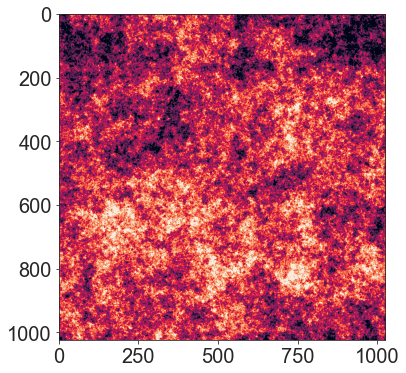

In [62]:
plt.figure(figsize=(6, 6))
vmax = np.quantile(np.abs(dj.delta_ini), 0.95)
plt.imshow(dj.delta_ini, cmap="rocket", vmin=-vmax, vmax=vmax)

In [63]:
dj.delta_ini.max()

Array(4.03486595, dtype=float64)

Let's also plot the initial potential

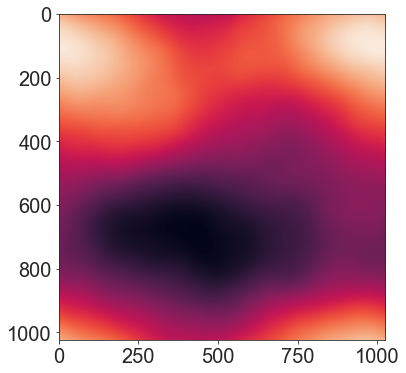

In [64]:
plt.figure(figsize=(6, 6))
plt.imshow(dj.phi_ini)

### Lagrangian perturbation theory (LPT)
Next, we compute the initial conditions with LPT. The order of the LPT computation can be set with the `n_order` parameter. Arbitrary LPT orders are supported, computed
with the recursion relation of Rampf et al., see [arXiv:2010.12584](https://arxiv.org/abs/2010.12584).

In [65]:
n_order = 9
dj = dj.with_lpt(n_order=n_order, convert_to_numpy=True)

### Particle-mesh (PM) N-body simulation
Now, we will run a particle-mesh (PM) N-body simulation. The following options need to be set:
- `stepper`: time integrator to use (choose between "symplectic" (standard symplectic integrator), "fastpm" (FastPM, https://arxiv.org/abs/1603.00476), "bullfrog" (BullFrog, see https://arxiv.org/abs/2301.09655 and https://arxiv.org/abs/2409.19049 for details)
- `method`: force computation method (choose between "pm", "nufftpm")
- `res_pm`: resolution of the PM grid
- `time_var`: time variable w.r.t. which uniform steps will be performed (choose between "a", "log_a", "superconft", "D")
- `antialias`: antialiasing factor (0, 1, 2, or 3): interlaced grids will be used for dealiasing
- `grad_kernel_order`: order of the gradient kernel (0: Fourier kernel ik, 2/4/6: 2nd/4th/6th order finite-difference kernel)
- `laplace_kernel_order`: order of the Laplacian kernel (0: Fourier kernel -k^2, 2/4/6: 2nd/4th/6th order finite-difference kernel)
- `n_resample`: resampling factor (1: no resampling, 2: resample particles 2x per dim., etc.). 
      This sheet-based resampling suppresses discreteness effects by artifically increasing the number of gravity-source particles through interpolation.
- `deconvolve`: deconvolve the mass assignment kernel (True/False)
- `n_steps`: number of time steps to run
- `nlpt_order_ics`: order of the LPT computation for the initial conditions (0: Zel'dovich, 1: 1LPT, 2: 2LPT, etc.)

Note: with the BullFrog integrator, starting the simulation at time a = 0 is possible, see [arXiv:2309.10865](https://arxiv.org/abs/2309.10865).

We will do a few steps and consider the fluid regime, where perturbation theory is still valid, to be able to compare the N-body simulation with LPT. Also, we will use high-accura cy settings for the force computation.

NOTE: while the following settings lead to very accurate results at early times, they are NOT suitable for the non-linear regime of 3D simulations, where the phase sheet is too complex to be accurately captured by sheet interpolation.

In [66]:
a_ini = 0.0
a_end = 0.5
stepper = "bullfrog"
method = "pm"
res_pm = 2 * dj.res
time_var = "a"
antialias = 2
grad_kernel_order = 0
laplace_kernel_order = 0
n_resample = 16
deconvolve = True
n_steps = 4  # 4 time steps
nlpt_order_ics = n_order

The method `run_nbody` returns the particle positions, the particle momenta, and the scale factor at the end of the simulation.

In [67]:
X_sim, P_sim, a_sim = dj.run_nbody(a_ini=a_ini, a_end=a_end, n_steps=n_steps, res_pm=res_pm, time_var=time_var,
                                   stepper=stepper, method=method, antialias=antialias,
                                   grad_kernel_order=grad_kernel_order, laplace_kernel_order=laplace_kernel_order,
                                   nlpt_order_ics=nlpt_order_ics, n_resample=n_resample, deconvolve=deconvolve)

In [68]:
X_sim.shape

(1024, 1024, 2)

In [69]:
X_lpt = dj.evaluate_lpt_pos_at_a(a_end, n_order=2)
delta_lpt = dj.get_delta_from_pos(X_lpt)
print(delta_lpt.std())

0.5084201941559267


0.5198464940461307


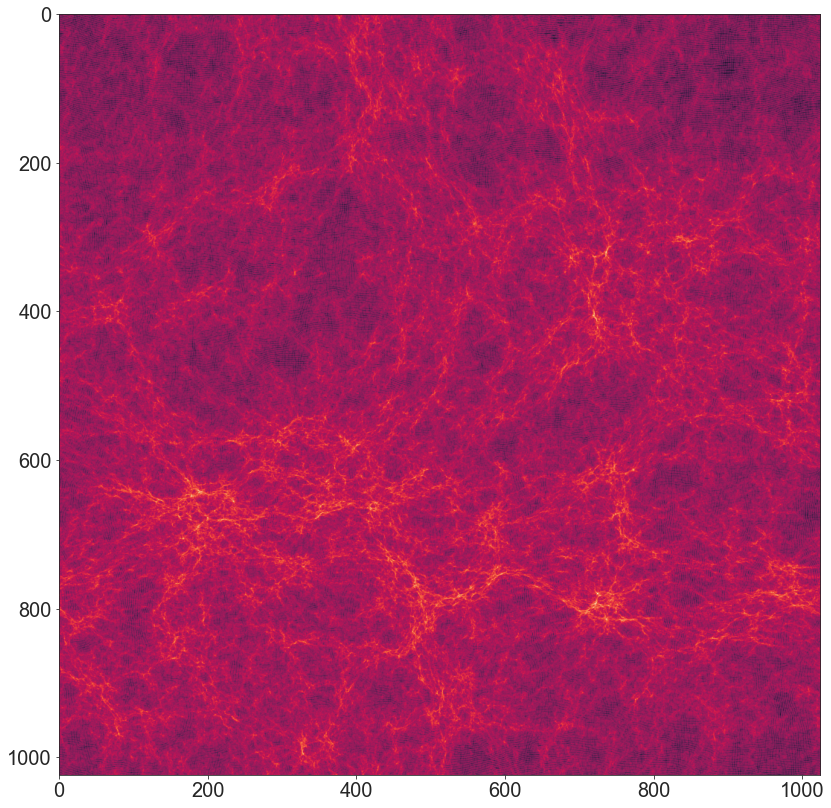

In [70]:
# Compute the density field from the particle positions
delta_sim = dj.get_delta_from_pos(X_sim)
plt.figure(figsize=(14, 14))
plt.imshow(np.log10(1.1 + delta_sim))
print(delta_sim.std())

### Analysis
We start with a comparison of the N-body density field with the LPT density fields at final time

Text(0.5, 1.0, '$\\delta_{CIC,Nbody}$')

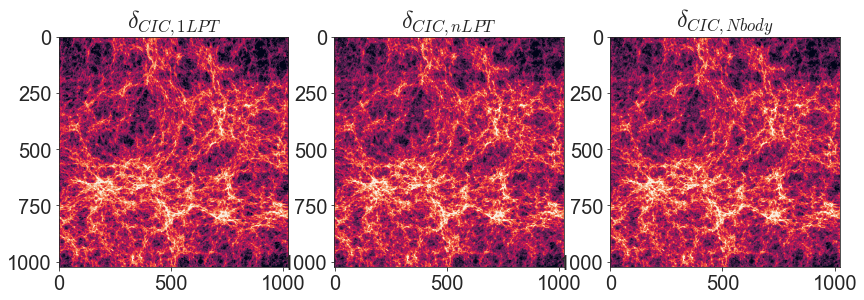

In [71]:
fig, ax = plt.subplots(1, 3, figsize=(14, 8))

X_lpt = dj.evaluate_lpt_pos_at_a(a_end, n_order)
delta_nlpt = dj.get_delta_from_pos(X_lpt)

X_1lpt = dj.evaluate_lpt_pos_at_a(a_end, 1)  # 1LPT (Zel'dovich) positions
delta_1lpt = dj.get_delta_from_pos(X_1lpt)  # 1LPT (Zel'dovich) density field

X_2lpt = dj.evaluate_lpt_pos_at_a(a_end, 2)  # 2LPT positions
delta_2lpt = dj.get_delta_from_pos(X_2lpt)  # 2LPT density field

std = 2 * np.std(np.log10(1.001 + delta_1lpt).flatten())
ax[0].imshow(np.log10(1.001 + delta_1lpt), vmin=-std, vmax=std)
ax[0].set_title('$\\delta_{CIC,1LPT}$', size=24)

ax[1].imshow(np.log10(1.001 + delta_nlpt), vmin=-std, vmax=std)
ax[1].set_title('$\\delta_{CIC,nLPT}$', size=24)

ax[2].imshow(np.log10(1.001 + delta_sim), vmin=-std, vmax=std)
ax[2].set_title('$\\delta_{CIC,Nbody}$', size=24)

Visually, the PM N-body simulation agrees well with the LPT predictions.

Pixelwise 2D histogram of the N-body density field vs. the LPT density fields

/tmp/ipykernel_75982/496424944.py:4: RuntimeWarning: divide by zero encountered in log10
  ax[0].hist2d(np.log10(1 + delta_sim.flatten()), np.log10(1 + delta_1lpt.flatten()), bins=[nb, nb],
/tmp/ipykernel_75982/496424944.py:9: RuntimeWarning: divide by zero encountered in log10
  ax[1].hist2d(np.log10(1 + delta_sim.flatten()), np.log10(1 + delta_2lpt.flatten()), bins=[nb, nb],
/tmp/ipykernel_75982/496424944.py:14: RuntimeWarning: divide by zero encountered in log10
  ax[2].hist2d(np.log10(1 + delta_sim.flatten()), np.log10(1 + delta_nlpt.flatten()), bins=[nb, nb],


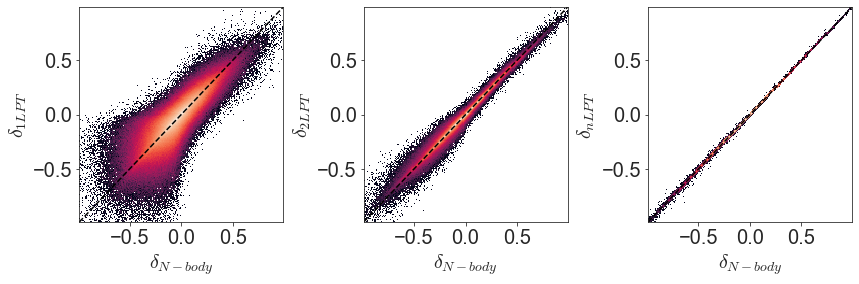

In [72]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
nb = 200
std = 5 * np.std(np.log10(1.001 + delta_1lpt).flatten())
ax[0].hist2d(np.log10(1 + delta_sim.flatten()), np.log10(1 + delta_1lpt.flatten()), bins=[nb, nb],
             range=[[-std, std], [-std, std]], norm=mpl.colors.LogNorm())
ax[0].plot([-std, std], [-std, std], 'k--')
ax[0].set_xlabel('$\\delta_{N-body}$')
ax[0].set_ylabel('$\\delta_{1LPT}$')
ax[1].hist2d(np.log10(1 + delta_sim.flatten()), np.log10(1 + delta_2lpt.flatten()), bins=[nb, nb],
             range=[[-std, std], [-std, std]], norm=mpl.colors.LogNorm())
ax[1].plot([-std, std], [-std, std], 'k--')
ax[1].set_xlabel('$\\delta_{N-body}$')
ax[1].set_ylabel('$\\delta_{2LPT}$')
ax[2].hist2d(np.log10(1 + delta_sim.flatten()), np.log10(1 + delta_nlpt.flatten()), bins=[nb, nb],
             range=[[-std, std], [-std, std]], norm=mpl.colors.LogNorm())
ax[2].plot([-std, std], [-std, std], 'k--')
ax[2].set_xlabel('$\\delta_{N-body}$')
ax[2].set_ylabel('$\\delta_{nLPT}$')
plt.tight_layout()

Upon closer inspection, it becomes clear that the match between 9LPT and the simulation is much better than for lower LPT orders.

We can also look at the power spectra of the density fields and the cross power spectra between the N-body density field and the LPT density fields.

(16,) (16,) (16,)


Text(0.5, 1.0, 'Normalized cross spectrum')

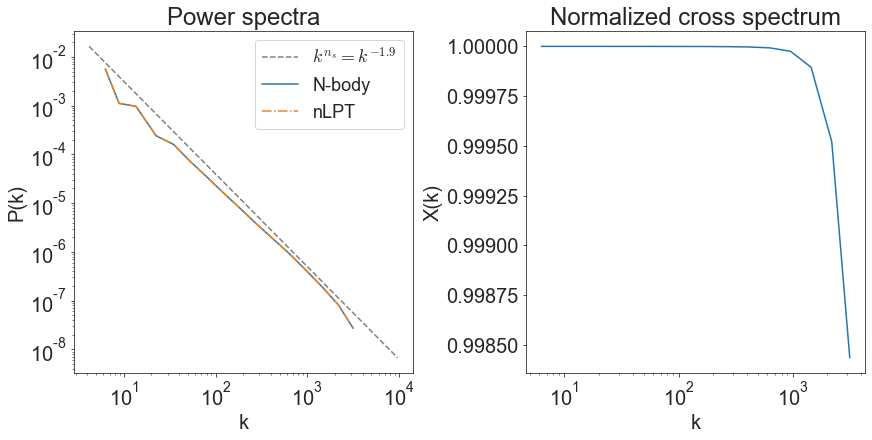

In [73]:
k, Xk, Pknb, PknLPT = dj.evaluate_cross_power_spectrum(delta_sim, delta_nlpt)
print(k.shape, Xk.shape, Pknb.shape)
fig, ax = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
efac = 1.5  # extend power law plot by this factor over actually measured range
kk = np.geomspace(1 / efac * 2 * np.pi, efac * np.pi * dj.res * 2, 8)
scalefac = 1.0
Pkk = kk ** dj.cosmo.n_s * a_end ** 2 * scalefac
ax[0].loglog(kk, Pkk, 'k--', alpha=0.5, label=rf'$k^{{n_s}} = k^{{{dj.cosmo.n_s:.1f}}}$')
ax[0].loglog(k, Pknb, "-", label='N-body')
ax[0].loglog(k, PknLPT, "-.", label='nLPT')

ax[0].set_xlabel('k')
ax[0].set_ylabel('P(k)')
ax[0].legend(fontsize=18)
ax[0].set_title('Power spectra')

ax[1].semilogx(k, Xk)
ax[1].set_xlabel('k')
ax[1].set_ylabel('X(k)')
ax[1].set_title('Normalized cross spectrum')


Finally, let us plot the residual between the N-body simulation and the LPT density fields.

LPT vs N-body residuals of the density fields:
1LPT: 0.1552
2LPT: 0.02645
3LPT: 0.008471
4LPT: 0.005662
5LPT: 0.005673
6LPT: 0.00549
7LPT: 0.005543
8LPT: 0.005507
9LPT: 0.005531


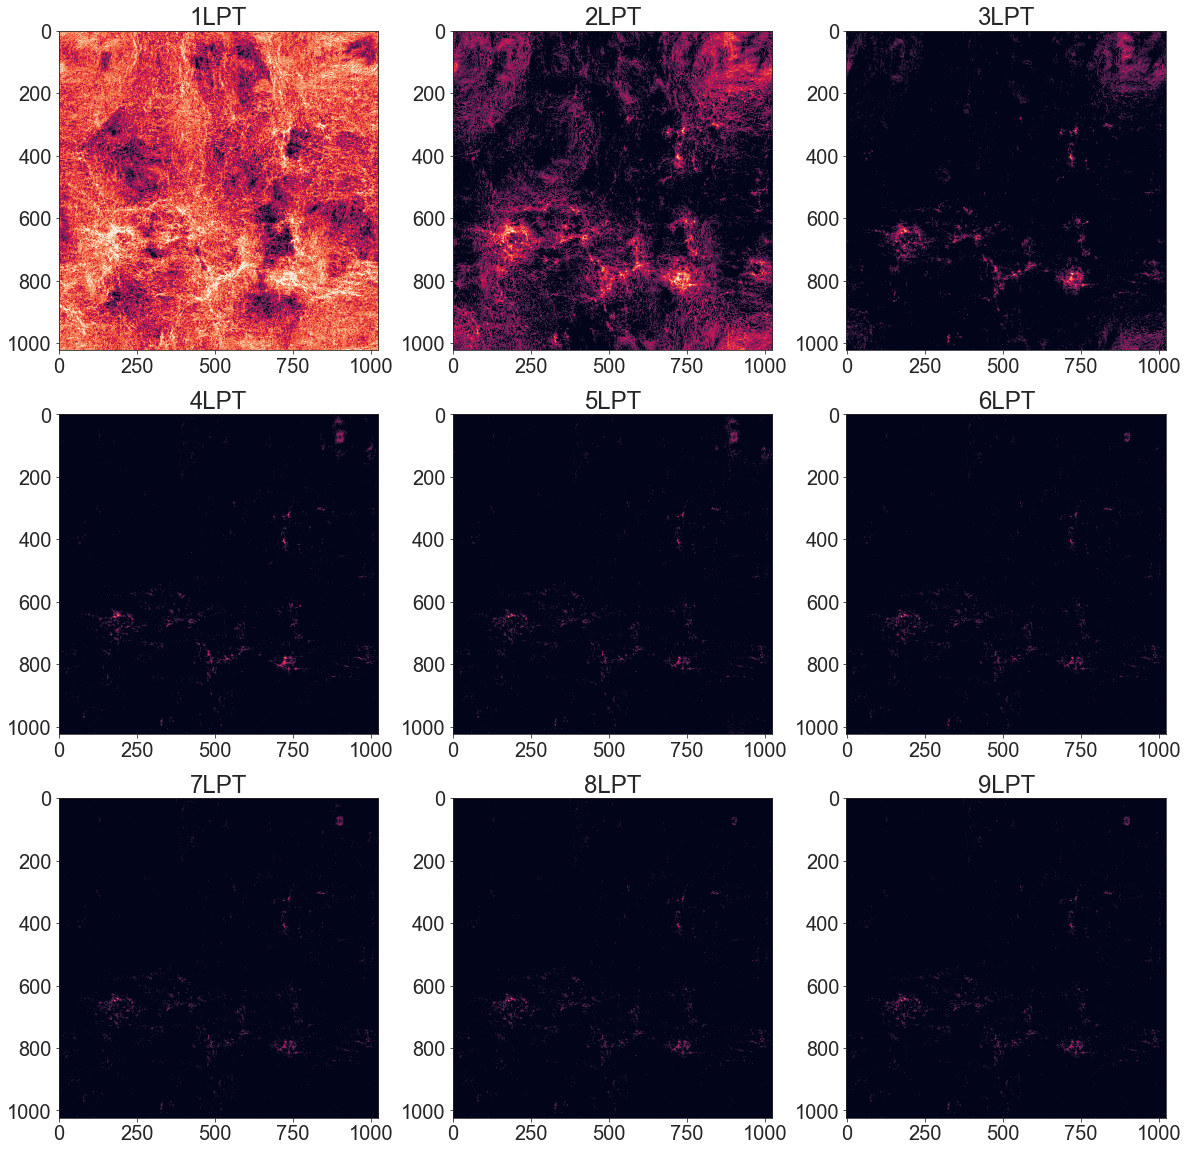

In [75]:
bfig, axs = plt.subplots(3, 3, figsize=(20, 20))
vmin = np.quantile(np.log10(np.abs(delta_1lpt - delta_sim)), 0.05)
vmax = np.quantile(np.log10(np.abs(delta_1lpt - delta_sim)), 0.95)

print("LPT vs N-body residuals of the density fields:")
for i in range(1, n_order + 1):
    X_ilpt = dj.evaluate_lpt_pos_at_a(a_end, i)
    delta_ilpt = dj.get_delta_from_pos(X_ilpt)
    res = np.abs(delta_ilpt - delta_sim)
    ix, iy = np.unravel_index(i - 1, (3, 3))
    axs[ix, iy].imshow(np.log10(1e-7 + res), vmin=vmin, vmax=vmax)
    axs[ix, iy].set_title(f"{i}LPT")
    print(f"{i}LPT: {np.mean(res):.4g}")
fig.suptitle("nLPT - N-body")
plt.show()

Going to 6LPT still leads to slight improvements in terms of the agreement with N-body - even higher orders don't help in this case.